# Libraries

In [2]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

# Adding Features

If you can't run the following code, (for example, kernel is crashed), please copy it to a separate python script because joblib doesn't work well in jupyter notebook.

In [ ]:
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import opinion_lexicon
from sklearn.feature_extraction.text import TfidfVectorizer



trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

sid = SentimentIntensityAnalyzer()

def get_compound_score(text):
    scores = sid.polarity_scores(str(text)) 
    return scores['compound']

def add_features_to(df):

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    positive_words = set(opinion_lexicon.positive())
    negative_words = set(opinion_lexicon.negative())
    negative_words.update(['nanjingdapaidang'])

    df['Score_filled'] = df['Score'].fillna(df['Score'].mean())

    df['ProductId_target_enc'] = df.groupby('ProductId')['Score_filled'].transform('mean')
    df['ProductId_count'] = df.groupby('ProductId')['ProductId'].transform('count')
    df['UserId_target_enc'] = df.groupby('UserId')['Score_filled'].transform('mean')
    df['UserId_count'] = df.groupby('UserId')['UserId'].transform('count')
    

    df['Date'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Hour'] = df['Date'].dt.hour

    def count_words(text, word_set):
        words = text.lower().split()  
        return sum(1 for word in words if word in word_set)

    df['Summary_positive_words'] = df['Summary'].apply(lambda x: count_words(str(x), positive_words))
    df['Summary_negative_words'] = df['Summary'].apply(lambda x: count_words(str(x), negative_words))
    df['Summary_Count_!'] = df['Summary'].apply(lambda x: str(x).count('!'))
    df['Summary_Count_?'] = df['Summary'].apply(lambda x: str(x).count('?'))
    df['Text_positive_words'] = df['Text'].apply(lambda x: count_words(str(x), positive_words))
    df['Text_negative_words'] = df['Text'].apply(lambda x: count_words(str(x), negative_words))
    df['Text_Count_!'] = df['Text'].apply(lambda x: str(x).count('!'))
    df['Text_Count_?'] = df['Text'].apply(lambda x: str(x).count('?'))

    summaries = df['Summary'].astype(str).tolist()
    texts = df['Text'].astype(str).tolist()

    df['Summary_sentiment_score'] = Parallel(n_jobs=-1)(delayed(get_compound_score)(text) for text in tqdm(summaries, desc="Processing Summary"))
    df['Text_sentiment_score'] = Parallel(n_jobs=-1)(delayed(get_compound_score)(text) for text in tqdm(texts, desc="Processing Text"))
    df['Comment_length'] = df['Text'].apply(lambda x: len(str(x))) 


    features_to_normalize = [
        'Helpfulness', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Comment_length', 
        'Time', 'Summary_sentiment_score', 'Text_sentiment_score', 'Summary_positive_words',
        'Summary_negative_words', 'Text_positive_words', 'Text_negative_words', 'ProductId_target_enc',
        'UserId_target_enc', 'ProductId_count', 'UserId_count', 'Summary_Count_!', 'Summary_Count_?',
        'Text_Count_!', 'Text_Count_?'
    ]
    
    scaler = StandardScaler()
    df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

    tfidf = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf.fit_transform(tqdm(df['Text'].astype(str), desc="TF-IDF Processing"))
    tfidf2 = TfidfVectorizer(max_features=200)
    tfidf_matrix2 = tfidf2.fit_transform(tqdm(df['Summary'].astype(str), desc="TF-IDF Processing"))
    tfidf_sparse_df = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=[f'TFIDF_{i}' for i in range(tfidf_matrix.shape[1])])
    tfidf_sparse_df2 = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix2, columns=[f'TFIDF_{i}' for i in range(1000, 1000+tfidf_matrix2.shape[1])])
    df = pd.concat([df, tfidf_sparse_df], axis=1)
    df = pd.concat([df, tfidf_sparse_df2], axis=1)


    return df

# Load the feature extracted files if they've already been generated
train = add_features_to(trainingSet)

# Merge on Id so that the submission set can have feature columns as well
X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
X_train =  train[train['Score'].notnull()]

X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [3]:
# Split training set into training and testing set
X_submission = pd.read_csv("./data/X_submission.csv")
X_train = pd.read_csv("./data/X_train.csv")

# you can add some features fast here
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=32
)

# Feature Selection

In [4]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'Comment_length', 
'Summary_sentiment_score', 'Text_sentiment_score', 'Summary_positive_words', 'Summary_negative_words',
'Text_positive_words', 'Text_negative_words', 'ProductId_target_enc', 'UserId_target_enc','Time', 
'Year', 'Month', 'Day', 'Hour', 'ProductId_count', 'UserId_count', 'Summary_Count_!', 'Summary_Count_?',
'Text_Count_!', 'Text_Count_?']
features.extend([f'TFIDF_{i}' for i in range(1200)])

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [11]:
from lightgbm import LGBMClassifier

# LightGBM
lgb_model = LGBMClassifier(n_estimators=500, max_depth=12, num_leaves=100, n_jobs=-1, learning_rate=0.1,
                            reg_lambda=10, reg_alpha=10, subsample=0.8, colsample_bytree=0.9, 
                            early_stopping_round=50, objective='multiclass', num_class=5, metric='multi_logloss')

lgb_model.fit(X_train_select, Y_train, eval_set=[(X_test_select, Y_test)], eval_metric='multi_logloss')
Y_train_predictions = lgb_model.predict(X_train_select)
train_accuracy = accuracy_score(Y_train, Y_train_predictions)
print("Train accuracy: ", train_accuracy)
Y_test_predictions = lgb_model.predict(X_test_select)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.743795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307047
[LightGBM] [Info] Number of data points in the train set: 1114005, number of used features: 1222
[LightGBM] [Info] Start training from score -2.790022
[LightGBM] [Info] Start training from score -2.808818
[LightGBM] [Info] Start training from score -2.135183
[LightGBM] [Info] Start training from score -1.487205
[LightGBM] [Info] Start training from score -0.627214
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.679598
Train accuracy:  0.7838366973218253
Accuracy on testing set =  0.7101385268328414


# Model Evaluation

Accuracy on testing set =  0.7101385268328414


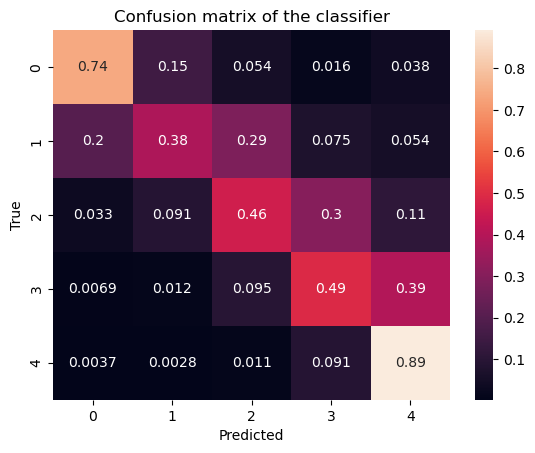

In [12]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [13]:
# Create the submission file
X_submission['Score'] = lgb_model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)